A jupyter notebook to test the code generation module

In [1]:
import os
import re
import string
import json
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Read the CSV file into a Pandas DataFrame
# print(os.getcwd())
calendar_data = pd.read_csv("../data/calendar_data.csv")
print(f"The number of calendar data is {len(calendar_data)}.")

with open("../data/question.json") as json_file:
    json_data = json.load(json_file)
    # print(json_data[question_index])

print(f"The number of the question is {len(json_data)}.")
print(f"Selected question is: {json_data[0]['question']}.")
print(f"Selected answer is: {json_data[0]['answer']}.")

The number of calendar data is 20.
The number of the question is 47.
Selected question is: How many meetings do I have attended in total?.
Selected answer is: 18.


In [20]:

MODEL = "gpt-4"
# MODEL = "gpt-3.5-turbo"

question_index = 9 # for question test

In [21]:
def get_completion(MODEL, PROMPT):
    if MODEL == "gpt-4":
        # print(f"""Model is: gpt-4""")
        client = OpenAI(
            api_key=os.environ.get("OPENAI_API_KEY"),
        )
    else:
        # print(f"""Model is: gpt-3.5 turbo""")
        client = OpenAI()

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": PROMPT,
            }
        ],
        model=MODEL, 
    )

    # verify the output
    return chat_completion.choices[0].message.content

In [22]:
def get_prompt(question):
    
    PROMPT = f"""You are provided a calendar dataset. This calendar is a Pandas dataframe named calendar_data, columns = [ID, status, summary, start, end , duration, attendees].
    This DataFrame calendar_data includes all of your meeting schedule. 
    Your task is generate python function to query this dataframe and answer the question. Use a Chain-of-Thought approach to break down the problem, analyze the date requirements, and then write the code in Python language. 

    The input have following columns:
    - ID: meeting ID;
    - status: meeting status, including the following status: cancelled, confirmed, tentative; cancelled means that meeting is cancelled.
    - summary: meeting or event topic;
    - start: the start date of meeting, date format: YYYY-MM-DD hh:mm:ss.fff-zz:xx. for example "2024-02-05 12:00:00-00:00";
    - end: the start date of meeting, date format: YYYY-MM-DD hh:mm:ss.fff-zz:xx, for example "2024-02-05 13:00:00-00:00";
    - duration: meeting duration (second);
    - attendees: people who attend the meeting delimited by the line terminator within 1 sentence.
    
    The python librtarys 

    Ensure any code you provide can be executed with all required imports and variables defined.
    The output should be a markdown python code snippet formatted in the following schema, including the leading and trailing "```python" and "```":
    ```python
    <your code here>
    ```

    For example, the output have the following format:
    ```python
    import pandas as pd 
    def query(calendar_data):
        return calendar_data[0]
    answer = query(calendar_data)
    ```
    
    Today's date is '2024-04-02 09:02:30', date format: %Y-%m-%d %H:%M:%S.

    Here is the question: {question} 
    """
    return PROMPT



In [23]:
def get_python_code(llm_reply_with_code):
    _python_code_re_pattern = "```python\n(.*?)```"
    llm_reply_without_code = re.sub(
                _python_code_re_pattern, "", llm_reply_with_code, flags=re.DOTALL
                )
    python_code_list = re.findall(_python_code_re_pattern, llm_reply_with_code, re.DOTALL)
    return python_code_list[0]

## Prompt without reflexion

In [24]:
# About 2.2 mins to run the code
# {'success': 16, 'wrong_answer': 12, 'error': 19}
# {'success': 16, 'wrong_answer': 12, 'error': 19}
# {'success': 15, 'wrong_answer': 11, 'error': 21}
# {'success': 15, 'wrong_answer': 26, 'error': 6}
# {'success': 15, 'wrong_answer': 12, 'error': 20}
# GPT-4

result_summary = {'success': 0, 'wrong_answer': 0, 'error': 0}
question_answer_summary = {'question': '',
                           'generated_code': '',
                           'true_answer':'', 
                           'answer': ''
                        }

q_a_pair_solution_list_for_json = []
result_prompt = []


for q_a_pair in json_data: 
    PROMPT = get_prompt(q_a_pair['question'])
    llm_reply_with_code = get_completion(MODEL, PROMPT)
    python_code_list = get_python_code(llm_reply_with_code)
    
    question_answer_summary['question'] = q_a_pair['question']
    question_answer_summary['true_answer'] = q_a_pair['answer']
    question_answer_summary['generated_code'] = python_code_list
    
    print(f"""Question: {q_a_pair['question']}\n True answer: {q_a_pair['answer']}""")



    try:
        exec(python_code_list)
    except Exception as E:
        question_answer_summary['answer'] = repr(E)
        print(f"""Non-executable code: {E}""")
        result_summary['error'] += 1
        pass
    else:
        try: 
            if q_a_pair['answer'] == answer:
                question_answer_summary['answer'] = 'success'
                result_summary['success'] += 1
            else:
                question_answer_summary['answer'] = repr(answer)
                print(f"""Wrong answer: {answer}""")
                result_summary['wrong_answer'] += 1
        except Exception as E:
            question_answer_summary['answer'] = repr(E)
            print(f"""Non-executable code: {E}""")
            result_summary['error'] += 1
            pass   
    
    result_prompt.append(result_summary.copy())
    # q_a_pair_solution_list_for_json.append(question_answer_summary.copy())
print(result_summary)

# save the result into JSON file.
# print(json.dumps(result_list, indent=4))
# with open('data.json', 'w', encoding='utf-8') as f:
#     json.dump(result_list, f, indent=4)
    

Question: How many meetings do I have attended in total?
 True answer: 18
Wrong answer: 0
Question: How many events do I have scheduled for today?
 True answer: 1
Wrong answer: 2
Question: How many attendees are there for the meeting with ID masbk72a24cb0a8k9c7jo0e9s6?
 True answer: 2
0
Wrong answer: 0
Question: What is the longest meeting ID on my calendar?
 True answer: malrq85j74yb0m3n8j8ro2v5d9
Wrong answer: 0
Question: How many events with duration longer than 1 hours?
 True answer: 6
Wrong answer: 0
Question: How many meeting were cancelled in total?
 True answer: 2
Wrong answer: 0
Question: How many events are scheduled today?
 True answer: 2
Question: How many events are scheduled tomorrow?
 True answer: 0
Wrong answer: 1
Question: Do I have me with natalia tomorrow, True or False?
 True answer: False
Has meeting with Natalia tomorrow:  False
Wrong answer: 1
Question: How many meeting did I have yestaerday ?
 True answer: 0
Question: How many meetings do I have for next 3 days?

<string>:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


Question: Do I have meeting in today afternoon, True or False?
 True answer: True
Wrong answer: False
Question: How many meetings do I have meeting in this afternoon?
 True answer: 1
Non-executable code: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp
Question: How many meetings have more than 10 attendees?
 True answer: 0
Question: How many meetings were scheduled for last weekend?
 True answer: 0
Question: How many meetings did I attended last week?
 True answer: 2
Non-executable code: 'Timestamp' object has no attribute 'start_of'
Question: How many meetings did I attended last three days?
 True answer: 0
Non-executable code: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp
Question: How many meetings do I have this tuesday?
 True answer: 2
Non-executable code: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead.
Question: Do I have meeting this tuesday, True or False?
 True answer: True
True
Que

## Prompt with reflexion

In [9]:
def get_prompt_for_refine(question, generated_code):
    
    PROMPT = f"""Reevaluate your previous generated python code for the question: {question}. For this question, a calendar dataset is provided. This calendar is a Pandas dataframe named calendar_data, columns = [ID, status, summary, start, end , duration, attendees].
    Based on the instructions, check the generated code, then write the new python code to ensure previous generated python code code can be executed with all required input, output and variables defined.
    
    **instruction**
    - The input is a dataFrame named 'calendar_data';
    - The output is a defined variables 'answer';
    - Today's date is '2024-04-02 09:02:30', date format: %Y-%m-%d %H:%M:%S.
    
    The new python code should be a markdown python code snippet formatted in the following schema, including the leading and trailing "```python" and "```":
    ```python
    <your code here>
    ```
    
    The previous generated code is:
    ```
    {generated_code}
    ```
    """
    return PROMPT



In [10]:
def get_prompt_with_error(question, generated_code, error_info):
    
    PROMPT = f"""You are expert in Python Debugging. For the question {question}, You have to analysis given python Code and Error and generate new python code that handles the error.
    *Instructions*:
    - Make sure to generate error free code
    - Generated code is able to handle the error
    - The input is a dataFrame named 'calendar_data';
    - The output is a defined variables 'answer';
    
    The new python code should be a markdown python code snippet formatted in the following schema, including the leading and trailing "```python" and "```":
    ```python
    <your code here>
    ```
    
    *Code*: {generated_code}
    
    *Error*: {error_info}
    """
    return PROMPT



In [13]:
# Generated Code Check
def code_generate_check(question):
    # code generation
    PROMPT = get_prompt(question)
    llm_reply_with_code = get_completion(MODEL, PROMPT)
    python_code_list = get_python_code(llm_reply_with_code)
    # code check
    # PROMPT_refine = get_prompt_for_refine(question, python_code_list)
    # llm_refine_reply_with_code = get_completion(MODEL, PROMPT_refine)
    # python_checked_code = get_python_code(llm_refine_reply_with_code)
    
    return python_code_list



def exec_code_check(question, generated_code, error_info):
    PROMPT_reflexion = get_prompt_with_error(question, generated_code, error_info)
    llm_reply_with_code = get_completion(MODEL, PROMPT_reflexion)
    python_reflexion_code = get_python_code(llm_reply_with_code)
    
    return python_reflexion_code


In [17]:
# {'success': 10, 'wrong_answer': 37, 'error': 0}
result_summary = {'success': 0, 'wrong_answer': 0, 'error': 0}
question_answer_summary = {'question': '',
                           'generated_code': '',
                           'true_answer':'', 
                           'answer': ''
                        }
q_a_pair_solution_list_for_json = []
result_prompt = []


for q_a_pair in json_data: 
    python_code_list = code_generate_check(q_a_pair['question'])
    
    question_answer_summary['question'] = q_a_pair['question']
    question_answer_summary['true_answer'] = q_a_pair['answer']
    question_answer_summary['generated_code'] = python_code_list
    # print(f"""Question: {q_a_pair['question']}\n True answer: {q_a_pair['answer']}""")

    print(q_a_pair['question'])
    
    iter = 0
    error_index = True
    while(error_index and iter<3):
        iter += 1
        try:
            exec(python_code_list)
            if (q_a_pair['answer'] == answer or True):
                error_index = False
                print(f"""Pass {iter}""")
        except Exception as E:
            print(f"""Recheck - Non-executable code type error: {E}""")
            python_code_list = exec_code_check(q_a_pair['question'], python_code_list, repr(E))
            pass
    
    try:
        exec(python_code_list)
    except Exception as E:
        question_answer_summary['answer'] = repr(E)
        print(f"""Non-executable code: {E}""")
        result_summary['error'] += 1
        pass
    else:
        try: 
            if q_a_pair['answer'] == answer:
                question_answer_summary['answer'] = 'success'
                result_summary['success'] += 1
            else:
                question_answer_summary['answer'] = repr(answer)
                print(f"""Wrong answer: {answer}""")
                result_summary['wrong_answer'] += 1
        except Exception as E:
            question_answer_summary['answer'] = repr(E)
            print(f"""Non-executable code: {E}""")
            result_summary['error'] += 1
            pass   
    
    result_prompt.append(result_summary.copy())
    # q_a_pair_solution_list_for_json.append(question_answer_summary.copy())
print(result_summary)

# save the result into JSON file.
# print(json.dumps(result_list, indent=4))
# with open('data.json', 'w', encoding='utf-8') as f:
#     json.dump(result_list, f, indent=4)
    

How many meetings do I have attended in total?
Pass 1
Wrong answer: 0
How many events do I have scheduled for today?
Pass 1
Wrong answer: 0
How many attendees are there for the meeting with ID masbk72a24cb0a8k9c7jo0e9s6?
Pass 1
Wrong answer: 0
What is the longest meeting ID on my calendar?
Pass 1
Wrong answer: 1
How many events with duration longer than 1 hours?
Pass 1
Wrong answer: 0
How many meeting were cancelled in total?
Pass 1
Wrong answer: 0
How many events are scheduled today?
Pass 1
Wrong answer: 0
How many events are scheduled tomorrow?
Pass 1
Do I have me with natalia tomorrow, True or False?
Pass 1
How many meeting did I have yestaerday ?
Recheck - Non-executable code type error: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp
Recheck - Non-executable code type error: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp
Pass 3
How many meetings do I have for next 3 days?
Pass 1
Wrong answer: 3
What is the topic of my last meeting?
Pass 1
Wro

## Performance analysis

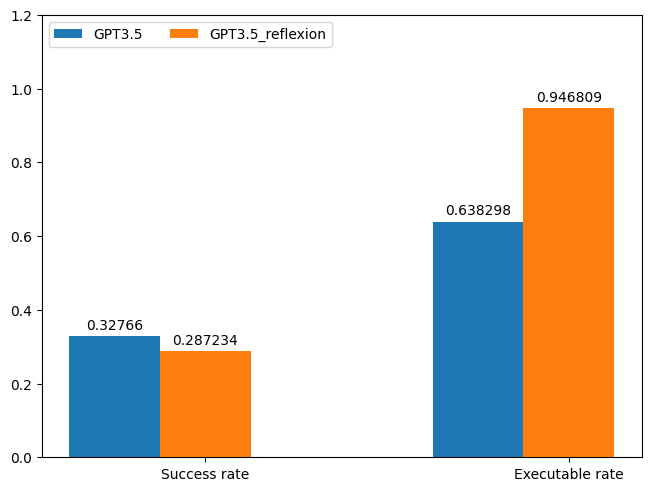

In [19]:
result_prompt = [
    {'success': 16, 'wrong_answer': 12, 'error': 19},
    {'success': 16, 'wrong_answer': 12, 'error': 19},
    {'success': 15, 'wrong_answer': 11, 'error': 21},
    {'success': 15, 'wrong_answer': 26, 'error': 6},
    {'success': 15, 'wrong_answer': 12, 'error': 20}
]

result_prompt_with_reflexion = [
    # {'success': 9, 'wrong_answer': 36, 'error': 2},
    {'success': 14, 'wrong_answer': 30, 'error': 3},
    {'success': 13, 'wrong_answer': 32, 'error': 2}
]


# Calculate average success rate and average error rate for each list
def calculate_average_rates(result_list):
    total_records = len(result_list)
    if total_records == 0:
        return 0, 0
    total_questions = sum(result_list[0].values())
    success_sum = sum(result['success'] for result in result_list)
    error_sum = sum(result['error'] for result in result_list)
    average_success_rate = success_sum / total_records/total_questions
    average_exec_rate = 1- error_sum / total_records/total_questions
    return average_success_rate, average_exec_rate


result_p_3_5_avg_success, result_p_3_5_avg_exec = calculate_average_rates(result_prompt)
result_p_4_w_r_avg_success, result_p_4_w_r_avg_exec = calculate_average_rates(result_prompt_with_reflexion)

performance = ("Success rate", "Executable rate")
penguin_means = {
    'GPT3.5': (result_p_3_5_avg_success, result_p_3_5_avg_exec),
    'GPT3.5_reflexion': (result_p_4_w_r_avg_success, result_p_4_w_r_avg_exec),
}

x = np.arange(len(performance))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width, performance)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1.2)

plt.show()

## BACKUP - Prompt without reflexion



In [ ]:
result_summary = {'success': 0, 'wrong_answer': 0, 'error': 0}
question_answer_summary = {'question': '',
                           'generated_code': '',
                           'true_answer':'', 
                           'answer': ''
                        }
q_a_pair_solution_list_for_json = []
result_prompt = []


for q_a_pair in json_data: 
    PROMPT = get_prompt(q_a_pair['question'])
    llm_reply_with_code = get_completion(MODEL, PROMPT)
    python_code_list = get_python_code(llm_reply_with_code)
    
    question_answer_summary['question'] = q_a_pair['question']
    question_answer_summary['true_answer'] = q_a_pair['answer']
    question_answer_summary['generated_code'] = python_code_list
    
    print(f"""Question: {q_a_pair['question']}\n True answer: {q_a_pair['answer']}""")

    try:
        exec(python_code_list)
    except Exception as E:
        question_answer_summary['answer'] = repr(E)
        print(f"""Non-executable code: {E}""")
        result_summary['error'] += 1
        pass
    else:
        try: 
            if q_a_pair['answer'] == answer:
                question_answer_summary['answer'] = 'success'
                result_summary['success'] += 1
            else:
                question_answer_summary['answer'] = repr(answer)
                print(f"""Wrong answer: {answer}""")
                result_summary['wrong_answer'] += 1
        except Exception as E:
            question_answer_summary['answer'] = repr(E)
            print(f"""Non-executable code: {E}""")
            result_summary['error'] += 1
            pass   
    
    result_prompt.append(result_summary.copy())
    # q_a_pair_solution_list_for_json.append(question_answer_summary.copy())
    # print(result)

# save the result into JSON file.
# print(json.dumps(result_list, indent=4))
# with open('data.json', 'w', encoding='utf-8') as f:
#     json.dump(result_list, f, indent=4)
    